<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/O2_prediction_model_Network_C_v2_O2T_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code related to the paper on the prediction of $[O2]$ and $T$ at the same time with MTL - Network C

## Dataset 2

In [183]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

# Keras

from tensorflow.keras.models import Sequential

#from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras import layers
import tensorflow.keras as keras

from keras.utils.vis_utils import plot_model

import tensorflow.keras.backend as K

from numpy import random

from scipy.interpolate import interp1d

from matplotlib.lines import Line2D

from matplotlib.patches import Patch

import seaborn as sns

# Read the files (Google Drive)

In [350]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [351]:
train_data_df = pd.read_csv('../data/train_data2.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets2.csv', names=['T', 'O2'], header = None)

# Read the files (Local files)

In [49]:
train_data_df = pd.read_csv('../data/train_data2.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets2.csv', names=['T', 'O2'], header = None)

In [50]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.535241,0.537692,0.537186,0.539902,0.54284,0.544292,0.546761,0.549564,0.552743,0.560122,...,0.790886,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
1,0.536566,0.536806,0.538521,0.540439,0.54239,0.544292,0.546761,0.549256,0.552183,0.559891,...,0.790804,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
2,0.536566,0.537692,0.537186,0.540439,0.54239,0.544292,0.546418,0.549256,0.552463,0.560122,...,0.790969,0.795041,0.799099,0.802755,0.806522,0.820096,0.832059,0.842727,0.85205,0.860323
3,0.536566,0.536806,0.539188,0.541512,0.54194,0.544681,0.546761,0.549256,0.552743,0.560122,...,0.790969,0.795041,0.799099,0.802918,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
4,0.537891,0.537692,0.537853,0.540439,0.54284,0.544292,0.547104,0.549564,0.552463,0.560582,...,0.790969,0.795041,0.799017,0.802837,0.806522,0.820255,0.832059,0.842727,0.85205,0.860552


In [51]:
train_target_df.head()

,T,O2
0,20.0,35.0
1,20.0,35.0
2,20.0,35.0
3,20.0,35.0
4,20.0,35.0


In [52]:
train_target_df[['O2']] = train_target_df[['O2']]/100.0
train_target_df[['T']] = train_target_df[['T']]/45.0

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [53]:
print(train_target_df['T'].unique())
print(train_target_df['T'].unique()*45)

[0.44444444 0.55555556 0.22222222 0.66666667 0.77777778 0.33333333
 0.88888889 1.         0.11111111]
[20. 25. 10. 30. 35. 15. 40. 45.  5.]


## Remove the records for [O2] = 0

In [54]:
train_data_df.shape

(3780, 50)

In [55]:
train_data_df[train_target_df['O2'] == 0].shape

(180, 50)

In [56]:
train_data_df.drop(train_data_df[train_target_df['O2'] == 0].index, inplace=True)
train_target_df.drop(train_target_df[train_target_df['O2'] == 0].index, inplace=True)
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);
print(train_data_df.shape)

(3600, 50)


## Dimensions

In [57]:
train_data_df.shape

(3600, 50)

In [58]:
train_target_df[train_target_df['T'] == 5./45.].shape

(400, 2)

To check how many values we have for each temperature we can do easily with ```groupby()```.

In [59]:
train_target_df.groupby('T')['O2'].nunique()

T
0.111111    20
0.222222    20
0.333333    20
0.444444    20
0.555556    20
0.666667    20
0.777778    20
0.888889    20
1.000000    20
Name: O2, dtype: int64

Each of the temperature has 5000 observations.

## Reset the index

In [60]:
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [61]:
np.unique(train_target_df['T'])*45

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

# Frequency values

In [62]:
wred = [  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.]

# Some plots

In [63]:
train_data_df[train_target_df['O2'] == 35/100.0]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.535241,0.537692,0.537186,0.539902,0.542840,0.544292,0.546761,0.549564,0.552743,0.560122,...,0.790886,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
1,0.536566,0.536806,0.538521,0.540439,0.542390,0.544292,0.546761,0.549256,0.552183,0.559891,...,0.790804,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
2,0.536566,0.537692,0.537186,0.540439,0.542390,0.544292,0.546418,0.549256,0.552463,0.560122,...,0.790969,0.795041,0.799099,0.802755,0.806522,0.820096,0.832059,0.842727,0.852050,0.860323
3,0.536566,0.536806,0.539188,0.541512,0.541940,0.544681,0.546761,0.549256,0.552743,0.560122,...,0.790969,0.795041,0.799099,0.802918,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
4,0.537891,0.537692,0.537853,0.540439,0.542840,0.544292,0.547104,0.549564,0.552463,0.560582,...,0.790969,0.795041,0.799017,0.802837,0.806522,0.820255,0.832059,0.842727,0.852050,0.860552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,0.554487,0.556040,0.557223,0.558001,0.560329,0.563077,0.566402,0.568445,0.571639,0.580336,...,0.813382,0.817335,0.820904,0.824531,0.827871,0.840492,0.851455,0.861019,0.869404,0.876933
1756,0.553247,0.556040,0.556598,0.558505,0.560329,0.562712,0.565758,0.568734,0.571902,0.580336,...,0.813382,0.817335,0.820984,0.824531,0.827871,0.840492,0.851455,0.861019,0.869404,0.876933
1757,0.554487,0.555210,0.557849,0.558505,0.560752,0.562712,0.565436,0.568734,0.571902,0.580553,...,0.813382,0.817254,0.820984,0.824611,0.827871,0.840492,0.851455,0.861019,0.869480,0.876933
1758,0.554487,0.556040,0.557223,0.558505,0.560329,0.563077,0.565436,0.568734,0.571639,0.580336,...,0.813382,0.817254,0.820984,0.824611,0.827951,0.840492,0.851455,0.861019,0.869480,0.876933


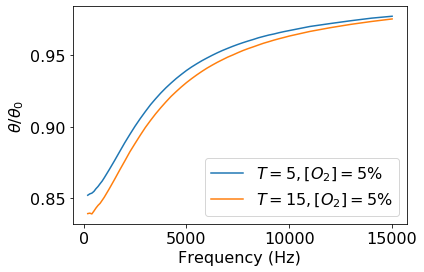

In [64]:
plt.plot(wred, train_data_df[(train_target_df['O2'] == 5./100.0) & (train_target_df['T'] == 5./45.0)].iloc[0], label ='$T=5, [O_2]=5 \%$')
plt.plot(wred, train_data_df[(train_target_df['O2'] == 5./100.0) & (train_target_df['T'] == 15./45.0)].iloc[0], label ='$T=15, [O_2]=5 \%$')
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / \theta_0$', fontsize = 16)
plt.show()

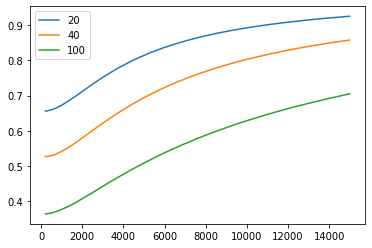

In [67]:
#plt.plot(wred, train_data_df[train_target_df['O2'] == 0/100.0].iloc[0], label ='0')
plt.plot(wred, train_data_df[train_target_df['O2'] == 20/100.0].iloc[0], label ='20')
plt.plot(wred, train_data_df[train_target_df['O2'] == 40/100.0].iloc[0], label ='40')
plt.plot(wred, train_data_df[train_target_df['O2'] == 100/100.0].iloc[0], label ='100')
plt.legend()
plt.show()

# Dataset split

In [68]:
np.random.seed(42)
rnd = np.random.rand(len(train_target_df)) < 0.8

In [69]:
data_train = train_data_df[rnd]
data_dev = train_data_df[~rnd]
targets_train = train_target_df[rnd]
targets_dev = train_target_df[~rnd]

In [70]:
np.min(np.min(data_train))

0.3324222501292755

In [71]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (2880, 50)
Number of dev      data observations is  (720, 50)


# Plot 1

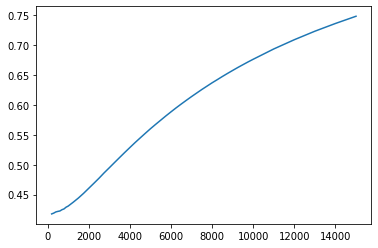

In [72]:
plt.plot(wred, train_data_df.iloc[200])

## Helper Functions

In [73]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks


def MAE_T_list_generator_w0(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0) & (targets_dev['O2'] > 0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [74]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [75]:
# Get predictions
def get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [76]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 5000 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return
        
class CustomCallbackProgress(keras.callbacks.Callback):
    
    def __init__(self, totalEpochs, step):
        self.step = 0
        self.totalEpochs = totalEpochs
        self.step = step
        
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 200 == 0):
            i = int(epoch / 200)
            
            if (i > 0):
                numberOfEquals = int(self.totalEpochs/200*i)
                percent = 100/(self.totalEpochs/200)*i
            else:
                numberOfEquals = 0
                percent = 0
                
                
            print ("\r[%-20s] %d%%" % ('='*i, percent), end='')
            
            if(percent == 100):
                print('')
        

In [77]:
def reset_keras():
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [78]:
def average_runs(n_iter, model_):
    MAE_O2_boxplot_avg = [0]*9
    MAE_T_boxplot_avg = [0]*5

    for i in range(n_iter):
        print ("Training iteration ", i)
        
        model_.fit(data_train, targets_train, epochs=4001, batch_size=1000,verbose = 0,
             validation_data= (data_dev, targets_dev), callbacks = [CustomCallbackProgress(4000,200)])

        print("Getting predictions for iteration ",i)
        targets_dev_, preds_df_ = get_predictions(model_, targets_dev, data_dev)
        targets_train_, preds_train_ = get_predictions(model_, targets_train, data_train)

        print("Generating MAE lists for iteration ", i)
        MAE_boxplot_, MAE_list_, MAE_xticks_ = MAE_O2_list_generator(10.0, targets_dev_, preds_df_)
        MAE_T_boxplot_, MAE_T_list_, MAE_T_xticks_ = MAE_T_list_generator(targets_dev_, preds_df_)
        #MAE_boxplot_train_, MAE_list_train_, MAE_xticks_train_ = MAE_list_generator(10.0, targets_train_, preds_train_)

        for j in range(len(MAE_boxplot_)):
            MAE_O2_boxplot_avg[j] = MAE_O2_boxplot_avg[j] + np.array(MAE_boxplot_[j])/n_iter
            
        for j in range(len(MAE_T_boxplot_)):
            MAE_T_boxplot_avg[j] = MAE_T_boxplot_avg[j] + np.array(MAE_T_boxplot_[j])/n_iter

    return MAE_O2_boxplot_avg, MAE_T_boxplot_avg

In [79]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

# Random Seed to get reproducible results

In [149]:
K.clear_session()

from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
#set_random_seed(42)

# Network C

In [150]:
class CustomCallback_(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 5000 == 0):
            print ("Just finished epoch", epoch)
            #print(logs)
            print ("Validation MAE_O2 = ", 100*float(logs.get("val_O2_output_mae")))
            print ("Validation MAE_T = ", 45*float(logs.get("val_T_output_mae")))
            print ("Training   MAE_O2 = ", 100*float(logs.get("O2_output_mae")))
            print ("Training   MAE_T = ", 45*float(logs.get("T_output_mae")))
            
            return

In [151]:
K.clear_session()

In [152]:
def get_compiled_model():
    input_x = keras.layers.Input(shape = (50,))
    lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
    lay2 = layers.Dense(50, activation='sigmoid')(lay1)
    lay3 = layers.Dense(50, activation='sigmoid')(lay2)
    outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

    lay4 = layers.Dense(5, activation='sigmoid')(lay3)
    lay5 = layers.Dense(5, activation='sigmoid')(lay4)
    outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


    lay6 = layers.Dense(5, activation='sigmoid')(lay3)
    lay7 = layers.Dense(5, activation='sigmoid')(lay6)
    outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

    #model = Model(input_x, outl)

    model4 = Model(
        inputs=input_x,
        outputs=[outboth, outo2, outT])
    
    losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
    }

    #0.3, 5, 5
    lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

    opt = Adam(lr=0.001)

    model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
            metrics=["mae"])
    
    return model4

In [153]:
input_x = keras.layers.Input(shape = (50,))
lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
lay2 = layers.Dense(50, activation='sigmoid')(lay1)
lay3 = layers.Dense(50, activation='sigmoid')(lay2)
outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

lay4 = layers.Dense(5, activation='sigmoid')(lay3)
lay5 = layers.Dense(5, activation='sigmoid')(lay4)
outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


lay6 = layers.Dense(5, activation='sigmoid')(lay3)
lay7 = layers.Dense(5, activation='sigmoid')(lay6)
outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

#model = Model(input_x, outl)

model4 = Model(
    inputs=input_x,
    outputs=[outboth, outo2, outT])

In [154]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           2550        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
______________________________________________________________________________________________

In [155]:
losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
}

#0.3, 5, 5
lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

opt = Adam(lr=0.001)

model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
        metrics=["mae"])

In [156]:
targets_train_O2 = targets_train['O2']
targets_dev_O2 = targets_dev['O2']
targets_train_T = targets_train['T']
targets_dev_T = targets_dev['T']

### Fitting of the model

In [157]:
H = model4.fit(data_train,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 32,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 0.8820544024308522, 'both_output_loss': 0.08401182, 'O2_output_loss': 0.08903945, 'T_output_loss': 0.08233068, 'both_output_mae': 0.24916749, 'O2_output_mae': 0.25559512, 'T_output_mae': 0.24724111, 'val_loss': 0.8538948562410142, 'val_both_output_loss': 0.08088627, 'val_O2_output_loss': 0.08312543, 'val_T_output_loss': 0.08245509, 'val_both_output_mae': 0.24763545, 'val_O2_output_mae': 0.24933161, 'val_T_output_mae': 0.2509486}
Just finished epoch 5000
{'loss': 0.0015903113497188314, 'both_output_loss': 0.0005797471, 'O2_output_loss': 1.5802165e-05, 'T_output_loss': 0.0002674753, 'both_output_mae': 0.016084224, 'O2_output_mae': 0.0029489454, 'T_output_mae': 0.01204794, 'val_loss': 0.0013916351004607148, 'val_both_output_loss': 0.00058314885, 'val_O2_output_loss': 2.0004427e-05, 'val_T_output_loss': 0.00022800178, 'val_both_output_mae': 0.01638336, 'val_O2_output_mae': 0.0033187687, 'val_T_output_mae': 0.0105151385}
Just finished epoch 10000
{'loss': 0.00

In [180]:
model4.save("model_20000_32_1e-3_3x50_2x5_2x5_theta_theta0.h5")

In [158]:
(O2T, O2, T) = model4.predict(data_dev)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [159]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

## For which [O2] AE_T is big?

In [171]:
#elmts = (targets_dev['T'] == T_/45.0)
tmp_ = targets_dev
tmp2_ = preds_exp_o2_df
mae_ = 100.0*np.abs(tmp2_['O2'].values- tmp_['O2'].values)

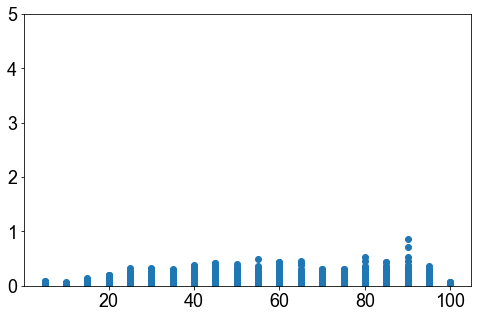

In [172]:
plt.figure(figsize = (8,5))
plt.scatter(100.0*tmp_['O2'], mae_)
plt.tick_params(labelsize=18)
#plt.xlim(5,100)
plt.ylim(0, 5)
plt.show()

In [181]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat_3 = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat_3 = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [163]:
len(MAET_list_C_MTL)

9

Note that the lists have not the same length, since the number of elements in each range is not equal, being the numbers randomly generated.

In [164]:
tmp = np.array([np.array(xi) for xi in MAE_boxplot_C])
#np.amax(MAE_boxplot_C)
for tmp_ in tmp:
    print('Number of elements =', tmp_.shape[0])

Number of elements = 36
Number of elements = 59
Number of elements = 74
Number of elements = 77
Number of elements = 81
Number of elements = 63
Number of elements = 66
Number of elements = 80
Number of elements = 64
Number of elements = 90


In [165]:
max = 0.0
for tmp_ in tmp:
    max_ = np.amax(tmp_)
    print(max_)
    if max_ > max:
        max = max_
        
print('The maximum is', max)

0.0965353846549985
0.1406854391098028
0.3251701593399048
0.3340911865234386
0.41901051998138317
0.4944097995758012
0.455275774002073
0.3157866001129106
0.5290102958679155
0.867185592651365
The maximum is 0.867185592651365


In [166]:
np.mean(MAE_list_C) 
# 64/32/32 -->
# 50       -->
# 80       -->

0.1280802298819315

<Figure size 432x288 with 0 Axes>

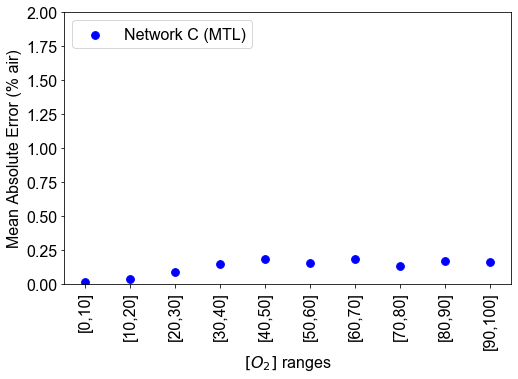

In [167]:
maxx = 4.0

plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1)

#bp = ax.scatter(range(1,len(MAE_xticks50)+1),MAE_list50, s = 60, color = 'black', label = 'Network A (50/50/50)')
#bp = ax.scatter(range(1,len(MAE_xticks_MTL)+1),MAE_list_MTL, s = 60, color = 'red', label = 'Network B (MTL)')
bp = ax.scatter(range(1,len(MAE_xticks_C)+1),MAE_list_C, s = 60, color = 'blue', label = 'Network C (MTL)')
plt.ylim(0, 2)
plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')
#plt.grid()
plt.ylabel('Mean Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges', fontsize = 16)
plt.tick_params(labelsize=16)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.xlim(0,9.5)


#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

W0221 06:47:14.591022 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0221 06:47:14.591876 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0221 06:47:14.628926 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0221 06:47:14.629530 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

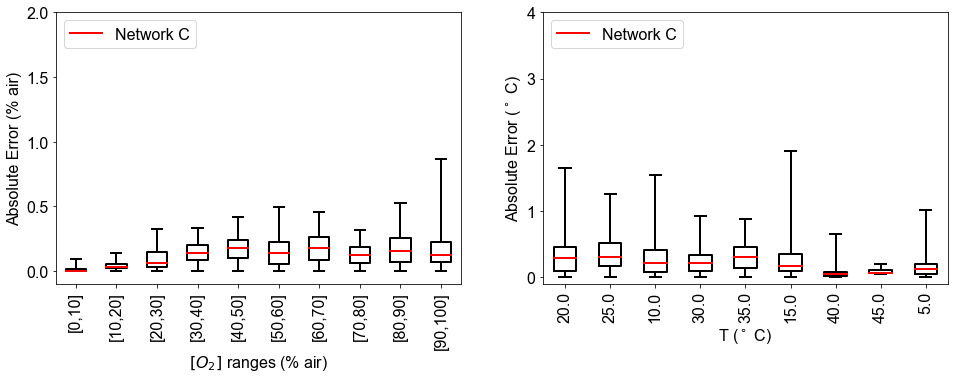

In [175]:
maxy = 2.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


bp = ax.boxplot(MAE_boxplot_C, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL)+1), MAET_xticks_C_MTL, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,4)

fig.savefig('../paper/result_theta_theta0.eps')

<Figure size 432x288 with 0 Axes>

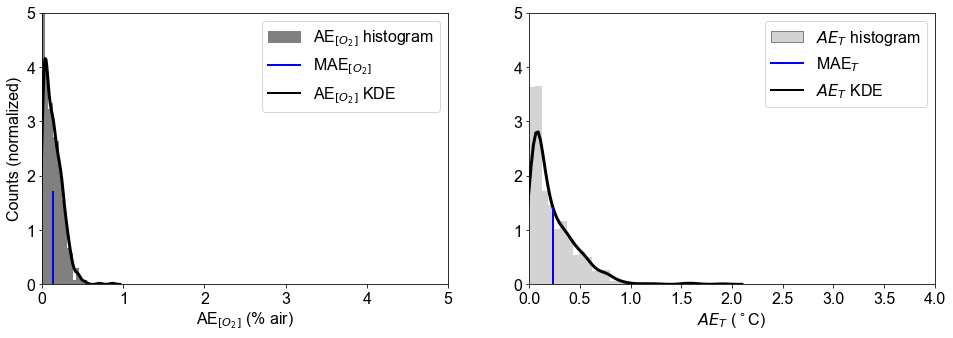

In [185]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ histogram', 'MAE$_{[O_2]}$', 'AE$_{[O_2]}$ KDE'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 5)
plt.xlim(0, 5)

m_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 1.7], lw = 2, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat_3,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='lightgray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['$AE_T$ histogram', 'MAE$_T$', '$AE_T$ KDE'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 5.0)
plt.xlim(0, 4)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 1.4], lw = 2, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

W0220 23:48:46.911154 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 23:48:46.911773 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 23:48:46.967643 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0220 23:48:46.968425 4485414336 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

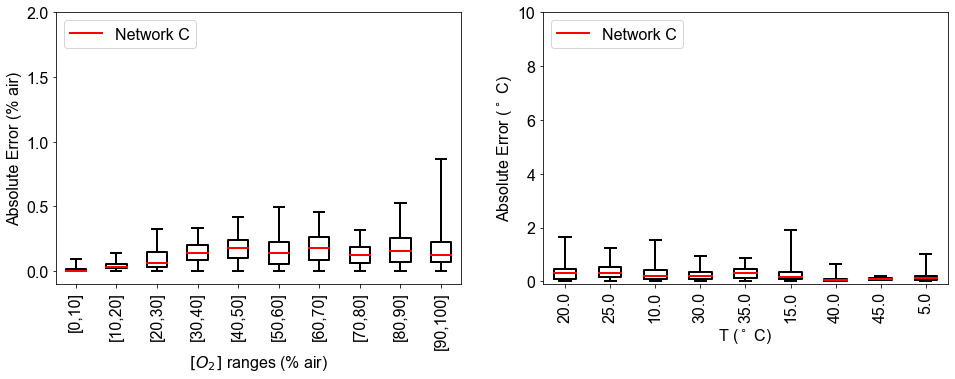

In [169]:
maxy = 2.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


bp = ax.boxplot(MAE_boxplot_C, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL_w0, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL_w0)+1), MAET_xticks_C_MTL_w0, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,10)

fig.savefig('../paper/result_theta_theta0.eps')

In [147]:
pdo2 = pd.DataFrame({'MAE_list': MAE_list_C, 'MAE_xticks': MAE_xticks_C, 'MAE_boxplot': MAE_boxplot_C})
pdT = pd.DataFrame({'MAET_list': MAET_list_C_MTL,'MAET_boxplot': MAET_boxplot_C_MTL, 'MAET_xticks':MAET_xticks_C_MTL})
#pdo2.to_csv('/content/gdrive/My Drive/data/netc_O2.csv')
#pdT.to_csv('/content/gdrive/My Drive/data/netc_T.csv')

In [176]:
np.mean(MAE_list_C)

0.1280802298819315

In [177]:
np.mean(MAET_list_C_MTL)

0.2369263850881598

In [178]:
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]
#type(MAE_boxplot_C)

In [179]:
np.max(MAET_boxplot_C_MTL_flat)

1.9086281955242166

<Figure size 432x288 with 0 Axes>

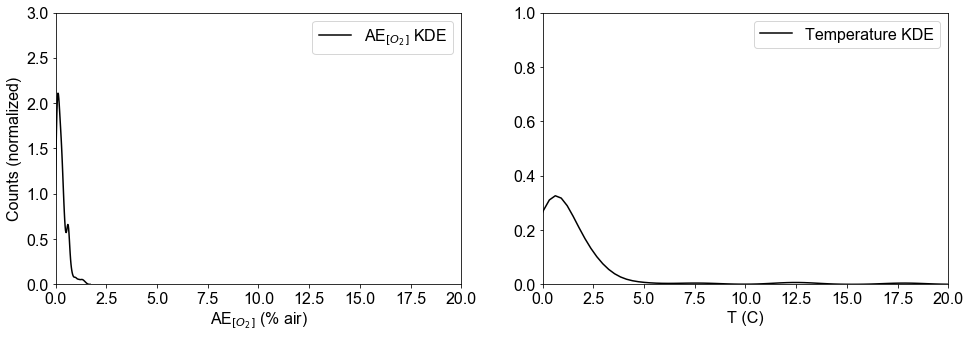

In [157]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'black', hist = False, label = 'AE$_{[O_2]}$ KDE')


ax.legend( fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 3)
plt.xlim(0, 20)


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,  color = 'black', hist = False, label = 'Temperature KDE')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('T (C)', fontsize = 16)
plt.tick_params(labelsize=16)
ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 20)




plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

# k-fold cross validation

In [261]:
from sklearn.model_selection import KFold

mean_aeo2 = []
mean_aeT = []
max_aeo2 = []
max_aeT = []

kf = KFold(n_splits=20)
indx = 1
for train_index, dev_index in kf.split(data_train):
    
    print('Evaluating fold combination number', indx)
    indx = indx + 1
    
    X_train, X_dev = data_train.iloc[train_index], data_train.iloc[dev_index]
    y_train, y_dev = targets_train.iloc[train_index], targets_train.iloc[dev_index]
    yO2_train, yO2_dev = targets_train_O2.iloc[train_index], targets_train_O2.iloc[dev_index]
    yT_train, yT_dev = targets_train_T.iloc[train_index], targets_train_T.iloc[dev_index]
    
    model4 = get_compiled_model()
    
    H = model4.fit(X_train,
        {"both_output": y_train, "O2_output": yO2_train, "T_output": yT_train},
        validation_data=(X_dev,
            {"both_output": y_dev, "O2_output": yO2_dev, "T_output": yT_dev}),
        epochs=20000, batch_size = 20000,
        verbose=0, callbacks = [CustomCallback()])
    
    (O2T, O2, T) = model4.predict(X_dev)
    preds_exp_df = pd.DataFrame(O2T)
    preds_exp_df.columns = ['O2', 'T']
    preds_exp_o2_df = pd.DataFrame(O2[:,0])
    preds_exp_o2_df.columns = ['O2']

    preds_exp_T_df = pd.DataFrame(T[:,0])
    preds_exp_T_df.columns = ['T']
    
    y_dev = y_dev.reset_index(drop = True)
    preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
    preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)
    
    MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, y_dev, preds_exp_o2_df)
    MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(y_dev, preds_exp_T_df)
    
    MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
    MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]
    
    mean_aeo2.append(np.mean(MAE_boxplot_C_flat))
    mean_aeT.append(np.mean(MAET_list_C_MTL))
    max_aeo2.append(np.max(MAE_boxplot_C_flat))
    max_aeT.append(np.max(MAET_boxplot_C_MTL_flat))
    
    print('Mean AE_[O2]', np.mean(MAE_boxplot_C_flat))
    print('Mean AE_T   ', np.mean(MAET_list_C_MTL))
    print('Max  AE_[O2]', np.max(MAE_boxplot_C_flat))
    print('Max  AE_T   ', np.max(MAET_boxplot_C_MTL_flat) )
    
    

Evaluating fold combination number 1
Just finished epoch 0
{'loss': 1.4292839765548706, 'both_output_loss': 0.10329197, 'O2_output_loss': 0.10224015, 'T_output_loss': 0.17741911, 'both_output_mae': 0.27193615, 'O2_output_mae': 0.26985186, 'T_output_mae': 0.34427506, 'val_loss': 1.1952961683273315, 'val_both_output_loss': 0.09990078, 'val_O2_output_loss': 0.13268225, 'val_T_output_loss': 0.10038294, 'val_both_output_mae': 0.25218692, 'val_O2_output_mae': 0.34736913, 'val_T_output_mae': 0.25369394}
Just finished epoch 5000
{'loss': 0.03464630991220474, 'both_output_loss': 0.0048582745, 'O2_output_loss': 0.0003040859, 'T_output_loss': 0.0063336794, 'both_output_mae': 0.041336887, 'O2_output_mae': 0.011467036, 'T_output_mae': 0.047881473, 'val_loss': 0.008282863534986973, 'val_both_output_loss': 0.002196752, 'val_O2_output_loss': 0.00049607054, 'val_T_output_loss': 0.001028697, 'val_both_output_mae': 0.03085738, 'val_O2_output_mae': 0.014105105, 'val_T_output_mae': 0.027063621}
Just finish

/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mean AE_[O2] 0.18081506797626737
Mean AE_T    0.8919845226462454
Max  AE_[O2] 0.9931218624114946
Max  AE_T    3.4086027741432186
Evaluating fold combination number 2
Just finished epoch 0
{'loss': 1.529355764389038, 'both_output_loss': 0.105253935, 'O2_output_loss': 0.14040847, 'T_output_loss': 0.15914744, 'both_output_mae': 0.274402, 'O2_output_mae': 0.307673, 'T_output_mae': 0.32643405, 'val_loss': 2.014242649078369, 'val_both_output_loss': 0.116922475, 'val_O2_output_loss': 0.17152621, 'val_T_output_loss': 0.22430696, 'val_both_output_mae': 0.2703353, 'val_O2_output_mae': 0.36253193, 'val_T_output_mae': 0.3853756}
Just finished epoch 5000
{'loss': 0.02990422025322914, 'both_output_loss': 0.0042009866, 'O2_output_loss': 0.00031883243, 'T_output_loss': 0.0054099523, 'both_output_mae': 0.03735191, 'O2_output_mae': 0.011189758, 'T_output_mae': 0.039169036, 'val_loss': 0.015123171731829643, 'val_both_output_loss': 0.0019369985, 'val_O2_output_loss': 0.00045859872, 'val_T_output_loss': 0.

In [262]:
print(mean_aeo2)
print(mean_aeT)
print(max_aeo2)
print(max_aeT)

[0.18081506797626737, 0.2481429516405294, 0.2851519792877281, 0.40836062741606133, 0.38150012008542816, 0.22494388041117258, 0.43314389730279507, 0.4922767151270468, 0.4632365116417801, 0.26380701252707794, 0.663255986245658, 0.5483980230370851, 0.4482670098740533, 0.277466012152614, 0.22367416473956706, 0.4138316105886856, 0.16254978968684852, 0.36042991051117257, 0.20637908600326832, 0.15687238104296097]
[0.8919845226462454, 0.8975860547806545, 0.833324495176173, 1.7302828948494517, 1.770491864033092, 1.590710004359506, 1.1999412570183692, 0.981418399023999, 1.4293420597716093, 1.7794269827524871, 4.172425461512013, 4.672701996452849, 1.2327903257277204, 0.6423918028529301, 1.5348551470175889, 3.0798429085737933, 0.6377906846403282, 2.984087319497938, 0.9331019072364938, 0.8539989204095324]
[0.9931218624114946, 1.241168975830076, 1.4112520217895552, 1.2110638618469283, 0.9584994614124293, 0.6950516253709793, 1.224462985992436, 1.193503141403196, 1.0320985317230247, 0.7706689834594771

In [260]:
mean_aeo2_1 = [0.22084727718987754, 0.3656032934835062, 0.22898283892826293, 0.36377462616848116, 0.39558034233905265, 0.42417326555128254, 0.427639719271501, 0.3572289889048827, 0.38599999614951824, 0.4216667673957181]
mean_aeT_1 = [1.4728898680414704, 1.6692693848778868, 1.0567906300734848, 1.3130502375999078, 1.0569985979052867, 3.4088957277249246, 1.4604857884012388, 2.3844622421948936, 1.589119701075373, 0.9898855057500944]
max_aeo2_1 = [1.0766720771789529, 1.2382078170776412, 1.1864435859024525, 1.3382422924041792, 1.4177686721086504, 1.025380752980709, 1.8180465698242165, 1.0034258477389812, 2.043560743331907, 1.0908389091491721]
max_aeT_1 = [4.789788126945495, 6.985730230808258, 6.957048475742338, 11.8645578622818, 6.718706637620926, 29.195796549320217, 3.3827295899391174, 21.631015241146088, 21.332902163267132, 2.622339427471161]

In [263]:
mean_aeo2_2 = [0.22084727718987754, 0.3656032934835062, 0.22898283892826293, 0.36377462616848116, 0.39558034233905265, 0.42417326555128254, 0.427639719271501, 0.3572289889048827, 
               0.38599999614951824, 0.4216667673957181, 0.18081506797626737, 0.2481429516405294, 0.2851519792877281, 0.40836062741606133, 0.38150012008542816, 0.22494388041117258, 
               0.43314389730279507, 0.4922767151270468, 0.4632365116417801, 0.26380701252707794, 0.663255986245658, 0.5483980230370851, 0.4482670098740533, 0.277466012152614, 
               0.22367416473956706, 0.4138316105886856, 0.16254978968684852, 0.36042991051117257, 0.20637908600326832, 0.15687238104296097]
mean_aeT_2 = [1.4728898680414704, 1.6692693848778868, 1.0567906300734848, 1.3130502375999078, 1.0569985979052867, 3.4088957277249246, 1.4604857884012388, 2.3844622421948936, 
              1.589119701075373, 0.9898855057500944, 0.8919845226462454, 0.8975860547806545, 0.833324495176173, 1.7302828948494517, 1.770491864033092, 1.590710004359506, 1.1999412570183692, 
              0.981418399023999, 1.4293420597716093, 1.7794269827524871, 4.172425461512013, 4.672701996452849, 1.2327903257277204, 0.6423918028529301, 1.5348551470175889, 3.0798429085737933, 
              0.6377906846403282, 2.984087319497938, 0.9331019072364938, 0.8539989204095324]
max_aeo2_2 = [1.0766720771789529, 1.2382078170776412, 1.1864435859024525, 1.3382422924041792, 1.4177686721086504, 1.025380752980709, 1.8180465698242165, 1.0034258477389812, 
              2.043560743331907, 1.0908389091491721, 0.9931218624114946, 1.241168975830076, 1.4112520217895552, 1.2110638618469283, 0.9584994614124293, 0.6950516253709793, 1.224462985992436, 1.193503141403196, 
              1.0320985317230247, 0.7706689834594771, 1.2212819419801235, 1.202670335769651, 2.2778844833374, 1.030951738357544, 0.7388615608215354, 1.054342370480299, 0.6807982921600342, 
              1.7965471744537331, 0.7728385925293013, 0.6240832805633589]
max_aeT_2 = [4.789788126945495, 6.985730230808258, 6.957048475742338, 11.8645578622818, 6.718706637620926, 29.195796549320217, 3.3827295899391174, 21.631015241146088, 
             21.332902163267132, 2.622339427471161, 3.4086027741432186, 2.121713161468506, 1.6914203763008113, 6.811241805553436, 6.00016474723816, 4.955916702747343, 
             10.799101293087006, 2.8931593894958496, 3.33897203207016, 4.600098803639412, 27.697801589965817, 16.755686700344086, 3.6268508434295654, 
             1.7204998433589926, 7.99917757511139, 22.51256212592125, 2.4865576624870305, 20.697115361690518, 2.52273291349411, 2.313469648361206]

# For which [O2] is AE_T big?

In [272]:
#elmts = (targets_dev['T'] == T_/45.0)
tmp_ = targets_dev
tmp2_ = preds_df
mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

NameError: name 'preds_df' is not defined

## Distributions of AEs

/Users/umberto/Python-Environments/tfenv2/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


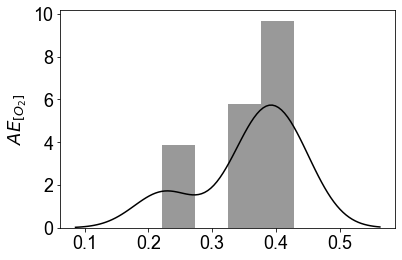

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(mean_aeo2, color = 'blue', edgecolor = 'black',
#         bins = 10)

# seaborn histogram
sns.distplot(mean_aeo2,  color = 'black', hist = True, label = 'KDE')
# Add labels
#plt.title('Boxplot of $AE_{[O_2]}$', fontsize = 18)
plt.tick_params(labelsize=18)
plt.xticks(None)
#plt.xlabel('Delay (min)')
#plt.xticks([])
plt.ylabel('$AE_{[O_2]}$', fontsize = 18)
plt.show()

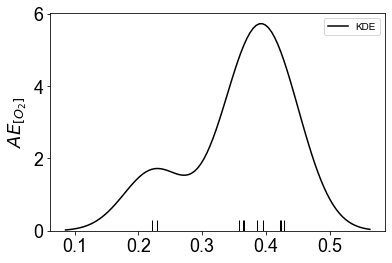

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(mean_aeo2, color = 'blue', edgecolor = 'black',
#         bins = 10)

# seaborn histogram
sns.distplot(mean_aeo2,  color = 'black', hist = False, rug=True, label = 'KDE')
# Add labels
#plt.title('Boxplot of $AE_{[O_2]}$', fontsize = 18)
plt.tick_params(labelsize=18)
plt.xticks(None)
#plt.xlabel('Delay (min)')
#plt.xticks([])
plt.ylabel('$AE_{[O_2]}$', fontsize = 18)
plt.show()

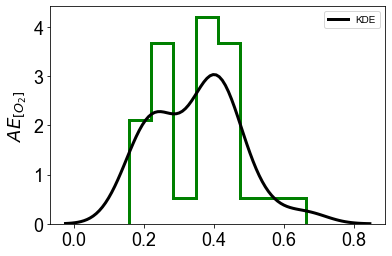

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(mean_aeo2, color = 'blue', edgecolor = 'black',
#         bins = 10)

# seaborn histogram
sns.distplot(mean_aeo2_2, norm_hist = True, rug=False, rug_kws={"color": "g"},
                   kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "step", "linewidth": 3,
                             "alpha": 1, "color": "g"},
                    bins = 8)
# Add labels
#plt.title('Boxplot of $AE_{[O_2]}$', fontsize = 18)
plt.tick_params(labelsize=18)
plt.xticks(None)
#plt.xlabel('Delay (min)')
#plt.xticks([])
plt.ylabel('$AE_{[O_2]}$', fontsize = 18)
plt.show()

<Figure size 576x288 with 0 Axes>

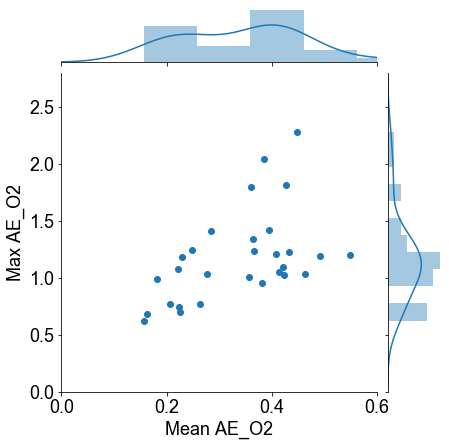

In [270]:


plt.figure(figsize=(8,4))
df = pd.DataFrame({'x': mean_aeo2_2, 'y': max_aeo2_2})

g = sns.JointGrid(x="x", y="y", data=df)
g = g.plot(plt.scatter, sns.distplot)
#g.fig.axes[0].invert_yaxis()

#g.plot_joint(plt.scatter, color=".5", edgecolor="white")
#g.plot_marginals(sns.distplot, kde=True, color=".5")

plt.tick_params(labelsize=18)
plt.xlabel('Mean AE_O2', fontsize = 18)
plt.ylabel('Max AE_O2', fontsize = 18)

plt.xlim(0, 0.6)
plt.ylim(0, 2.8)

plt.show()

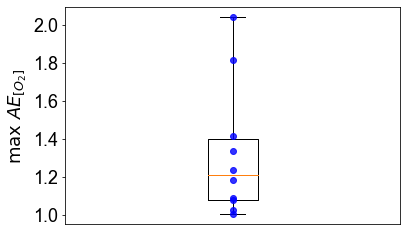

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(mean_aeo2, color = 'blue', edgecolor = 'black',
#         bins = 10)

# seaborn histogram
box=plt.boxplot(max_aeo2, whis = 'range')#,patch_artist=True)
#for patch, color in zip(box['boxes'], ['lightblue']):
#    patch.set_facecolor(color)
# Add labels
#plt.title('Boxplot of $AE_{[O_2]}$', fontsize = 18)
plt.tick_params(labelsize=18)
plt.xticks(None)
#plt.xlabel('Delay (min)')
plt.xticks([])
plt.ylabel('$\max \ AE_{[O_2]}$', fontsize = 18)
plt.plot([1]*len(max_aeo2), max_aeo2, 'b.', alpha=0.8,markersize=12)
plt.show()

# VERSIONS

In [83]:
#import tensorflow as tf
#from tensorflow.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

2.1.0-rc1
2.2.4-tf
